In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
pacs = pd.read_csv('Campaign_Finance_data/pacs_all.csv', encoding = "ISO-8859-1")
conginvest = pd.read_csv('Goal1_PFD_1of3.csv', encoding = "ISO-8859-1")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cmte = pd.read_csv('Campaign_Finance_data/cmtes_all.csv', encoding = "ISO-8859-1")
pacs = pacs.merge(cmte[['CmteID', 'PACShort']], left_on='PACID', right_on='CmteID', how='left').drop('CmteID', axis=1)

temp = pacs[['Cycle','PACID','PACShort']].drop_duplicates()

print('Number of PACIDs with multiple organization names: ',
    len(temp.groupby(['Cycle','PACID'])['PACShort'].size().reset_index(). \
        query('PACShort > 1'))) #16723 

del temp, cmte

Number of PACIDs with multiple organization names:  16723


In [4]:
# RealCodeOut is congresspeople investing
# RealCodeIn is industry giving money to congresspeople
conginvest = conginvest[['CID', 'RealCode']].rename(columns={'RealCode':'RealCodeOut'}). \
    groupby(['CID','RealCodeOut']).size().reset_index(name='NumInvestments')
pacs = pacs[['Cycle', 'CID', 'PACID', 'Amount', 'RealCode']].rename(columns={'RealCode':'RealCodeIn'})

In [5]:
contributions = pacs. \
    groupby(['PACID', 'RealCodeIn', 'CID'])['Amount']. \
    sum().reset_index()

print(len(contributions))
contributions.head()

920282


,PACID,RealCodeIn,CID,Amount
0,C00000026,H1500,N00000209,2500
1,C00000026,H1500,N00000659,5000
2,C00000026,H1500,N00000756,42630
3,C00000026,H1500,N00000817,2500
4,C00000026,H1500,N00001022,500


In [6]:
df = contributions.merge(conginvest, 
                         left_on=['CID','RealCodeIn'], right_on=['CID','RealCodeOut'], how='left'). \
                        drop('RealCodeOut', axis=1). \
                        rename(columns={'RealCodeIn': 'RealCode'})
df.dropna().head()

,PACID,RealCode,CID,Amount,NumInvestments
78,C00000042,M2300,N00000561,162500,19.0
87,C00000042,M2300,N00001489,45500,1.0
99,C00000042,M2300,N00002097,13000,4.0
103,C00000042,M2300,N00002315,52000,10.0
105,C00000042,M2300,N00002328,26000,5.0


In [62]:
industry_df = df.groupby(['RealCode', 'CID'])['Amount', 'NumInvestments']. \
    sum().reset_index()

industry_df.dropna().head()

,RealCode,CID,Amount,NumInvestments
21,A0000,N00004645,6000,3.0
29,A0000,N00005559,31000,6.0
31,A0000,N00006263,12000,2.0
108,A1000,N00001329,52000,1.0
113,A1000,N00001510,91000,9.0


In [24]:
industry_subset = pd.DataFrame(industry_df.dropna()[:50])

G = nx.from_pandas_dataframe(industry_subset, 'RealCode', 'CID', ['Amount', 'NumInvestments'])
#nx.write_graphml(G, 'investmentlinks.graphml')

In [90]:
node_size = industry_subset.groupby('RealCode')['Amount'].sum().to_dict()

temp = industry_subset.groupby('CID')['Amount'].sum().to_dict()
for key, value in temp.items(): temp[key] = 0
node_size.update(temp)
del temp

nx.set_node_attributes(G, node_size, 'size')

nx.get_node_attributes(G, 'size')

{'A0000': 49000,
 'A1000': 6297700,
 'N00001329': 0,
 'N00001510': 0,
 'N00001758': 0,
 'N00002091': 0,
 'N00002269': 0,
 'N00002315': 0,
 'N00002383': 0,
 'N00002743': 0,
 'N00002877': 0,
 'N00003028': 0,
 'N00003062': 0,
 'N00003254': 0,
 'N00003288': 0,
 'N00003675': 0,
 'N00003682': 0,
 'N00003709': 0,
 'N00004208': 0,
 'N00004227': 0,
 'N00004436': 0,
 'N00004484': 0,
 'N00004558': 0,
 'N00004645': 0,
 'N00004698': 0,
 'N00004781': 0,
 'N00004905': 0,
 'N00005165': 0,
 'N00005178': 0,
 'N00005195': 0,
 'N00005244': 0,
 'N00005282': 0,
 'N00005353': 0,
 'N00005455': 0,
 'N00005559': 0,
 'N00006060': 0,
 'N00006263': 0,
 'N00006283': 0,
 'N00007099': 0,
 'N00007248': 0,
 'N00008032': 0,
 'N00008092': 0,
 'N00009888': 0,
 'N00009954': 0,
 'N00012586': 0,
 'N00013131': 0,
 'N00013323': 0,
 'N00025054': 0,
 'N00026041': 0}

In [107]:
G['A0000']['N00005559']

sizes = [nodes[i]['size'] for i in nodes]
for i in range(len(sizes)):
    if sizes[i] < 1:
        sizes[i] = 100
    else:
        sizes[i] = 500
        
print(sizes)

[500, 100, 100, 100, 500, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


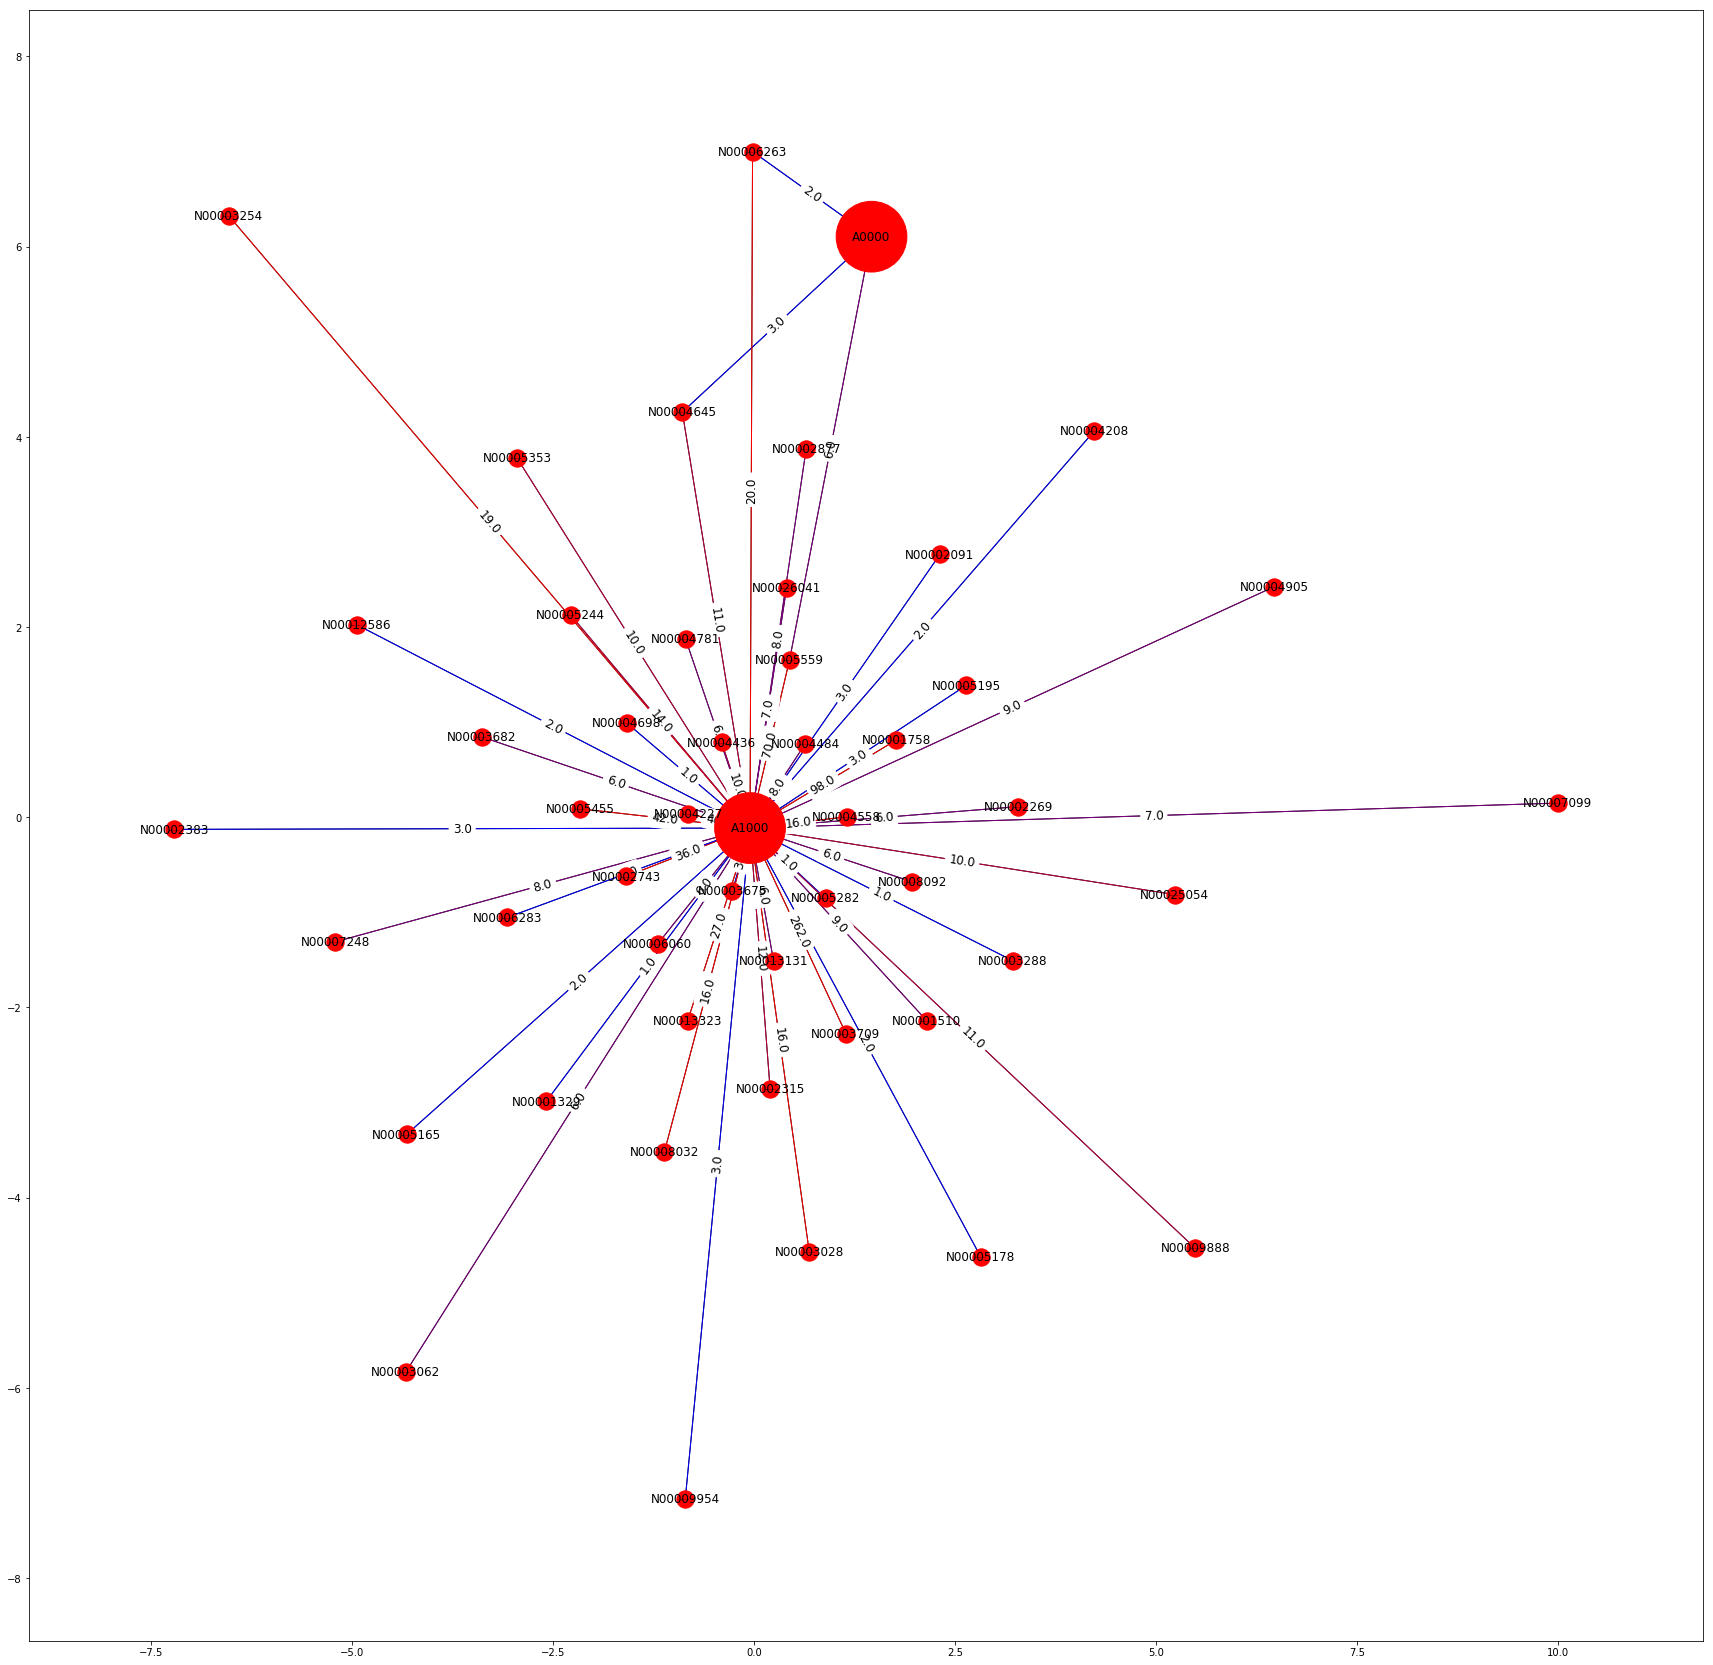

In [108]:
pos = nx.spring_layout(G, scale=10, weight='Amount', k=10)
plt.figure(figsize=(30,30))
nx.draw_networkx(G, pos)

nx.draw_networkx_labels(G, pos, font_size=2)


sizes = [nodes[i]['size'] for i in nodes]
for i in range(len(sizes)):
    if sizes[i] < 1:
        sizes[i] = 100
    else:
        sizes[i] = 5000

nx.draw_networkx_nodes(G, pos, node_size=sizes)

edges = G.edges()
colors = [G[u][v]['NumInvestments'] for u,v in edges]
for i in range(len(colors)):
    if colors[i]<5:
        colors[i] = '#0000ff'
    elif colors[i]<10:
        colors[i] = '#800080'
    elif colors[i]<15:
        colors[i] = '#bf0040'
    else:
        colors[i] = '#ff0000'


weights = [G[u][v]['Amount'] for u,v in edges]
# decided not to use weights because it makes it harder to
# use the number of nodes we have

nx.draw_networkx_edges(G, pos, edge_color = colors)#, width=log(weights))

edge_labels = nx.get_edge_attributes(G,'NumInvestments')
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=12)

plt.savefig('graph.pdf', dpi=800)
# the closer the node, the greater the amount the industry has contributed to that congressperson

In [53]:
#nx.write_gpickle(G,"test.gpickle")

AttributeError: 'NoneType' object has no attribute 'show'